First step, we need to upload and work with our dataset. format and homogeneize the data


First we need to isntall some packages using PIP 

In [3]:
!pip install patchify
!pip install segmentation-models

     |████████████████████████████████| 50 kB 5.9 MB/s 


imports

In [4]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

Segmentation Models: using `keras` framework.


or execute the cell bewlow to download and unzip in your root colab session folder

In [2]:
!wget https://www.dropbox.com/s/3wua98ksdjyrlfi/dataset.zip

--2022-02-25 17:08:42--  https://www.dropbox.com/s/3wua98ksdjyrlfi/dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3wua98ksdjyrlfi/dataset.zip [following]
--2022-02-25 17:08:42--  https://www.dropbox.com/s/raw/3wua98ksdjyrlfi/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucefd39ce80f2324019ed062d263.dl.dropboxusercontent.com/cd/0/inline/BgaccHxO8Rzqj0VUxu87DEeAyXgdxufVYPo0uxPrw9aseIsRnpm7PNi2umoCEotsEeB_3H-Ibiw0viWSELH1J-n8O13cG8wfvBgynBPrb0spkmWDdR83pKBOABQq0n0ddo5I68qC1hQvJXStrPbWHhy4/file# [following]
--2022-02-25 17:08:43--  https://ucefd39ce80f2324019ed062d263.dl.dropboxusercontent.com/cd/0/inline/BgaccHxO8Rzqj0VUxu87DEeAyXgdxufVYPo0uxPrw9aseIsRnpm7PNi2umoCEotsEeB_3H-Ibiw0viWSELH1J-n8O1

In [5]:
#make directory for data
!mkdir Data

In [8]:
#unzip dataset into folder 
!unzip /content/dataset.zip -d /content/Data/

Archive:  /content/dataset.zip
  inflating: /content/Data/unet_segmentation.hdf5  
  inflating: /content/Data/Semantic segmentation dataset/classes.json  
  inflating: /content/Data/Semantic segmentation dataset/.DS_Store  
  inflating: /content/Data/Semantic segmentation dataset/Tile 6/.DS_Store  
  inflating: /content/Data/Semantic segmentation dataset/Tile 1/images/image_part_007.jpg  
  inflating: /content/Data/Semantic segmentation dataset/Tile 1/images/image_part_001.jpg  
  inflating: /content/Data/Semantic segmentation dataset/Tile 1/images/image_part_004.jpg  
  inflating: /content/Data/Semantic segmentation dataset/Tile 1/images/image_part_009.jpg  
  inflating: /content/Data/Semantic segmentation dataset/Tile 1/images/image_part_005.jpg  
  inflating: /content/Data/Semantic segmentation dataset/Tile 1/images/image_part_002.jpg  
  inflating: /content/Data/Semantic segmentation dataset/Tile 1/images/image_part_008.jpg  
  inflating: /content/Data/Semantic segmentation dataset

In [9]:
root_directory = '/content/Data/Semantic segmentation dataset/'

patch_size = 256

#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  

we will look into the folder and subfolders and apply some trasnsformations to images 

In [10]:
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
                
  

Now patchifying image: /content/Data/Semantic segmentation dataset/Tile 6/images/image_part_008.jpg
Now patchifying image: /content/Data/Semantic segmentation dataset/Tile 6/images/image_part_006.jpg
Now patchifying image: /content/Data/Semantic segmentation dataset/Tile 6/images/image_part_009.jpg
Now patchifying image: /content/Data/Semantic segmentation dataset/Tile 6/images/image_part_005.jpg
Now patchifying image: /content/Data/Semantic segmentation dataset/Tile 6/images/image_part_007.jpg
Now patchifying image: /content/Data/Semantic segmentation dataset/Tile 6/images/image_part_001.jpg
Now patchifying image: /content/Data/Semantic segmentation dataset/Tile 6/images/image_part_003.jpg
Now patchifying image: /content/Data/Semantic segmentation dataset/Tile 6/images/image_part_002.jpg
Now patchifying image: /content/Data/Semantic segmentation dataset/Tile 6/images/image_part_004.jpg
Now patchifying image: /content/Data/Semantic segmentation dataset/Tile 5/images/image_part_008.jpg


Now do the same as above for masks
 For this specific dataset we could have added masks to the above code as masks have extension png

In [11]:
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 

Now patchifying mask: /content/Data/Semantic segmentation dataset/Tile 6/masks/image_part_006.png
Now patchifying mask: /content/Data/Semantic segmentation dataset/Tile 6/masks/image_part_004.png
Now patchifying mask: /content/Data/Semantic segmentation dataset/Tile 6/masks/image_part_007.png
Now patchifying mask: /content/Data/Semantic segmentation dataset/Tile 6/masks/image_part_005.png
Now patchifying mask: /content/Data/Semantic segmentation dataset/Tile 6/masks/image_part_001.png
Now patchifying mask: /content/Data/Semantic segmentation dataset/Tile 6/masks/image_part_008.png
Now patchifying mask: /content/Data/Semantic segmentation dataset/Tile 6/masks/image_part_003.png
Now patchifying mask: /content/Data/Semantic segmentation dataset/Tile 6/masks/image_part_009.png
Now patchifying mask: /content/Data/Semantic segmentation dataset/Tile 6/masks/image_part_002.png
Now patchifying mask: /content/Data/Semantic segmentation dataset/Tile 5/masks/image_part_006.png
Now patchifying mask

convert our datasets to np arrays

In [12]:

image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)


perform a sanity check 

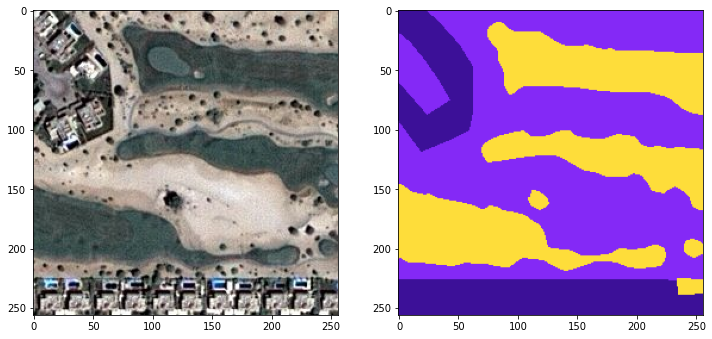

In [14]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

Because the masks are in RGB values, we need to convert everything to HEX

RGB to HEX: (Hexadecimel --> base 16)
This number divided by sixteen (integer division; ignoring any remainder) gives 
the first hexadecimal digit (between 0 and F, where the letters A to F represent 
the numbers 10 to 15). The remainder gives the second hexadecimal digit. 
0-9 --> 0-9
10-15 --> A-F
Example: RGB --> R=201, G=, B=
R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)
Calculating RGB from HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152

In [15]:
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg


labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))


60
Unique labels in label dataset are:  [0 1 2 3 4 5]


we perform another sanitu check (view some of the images)

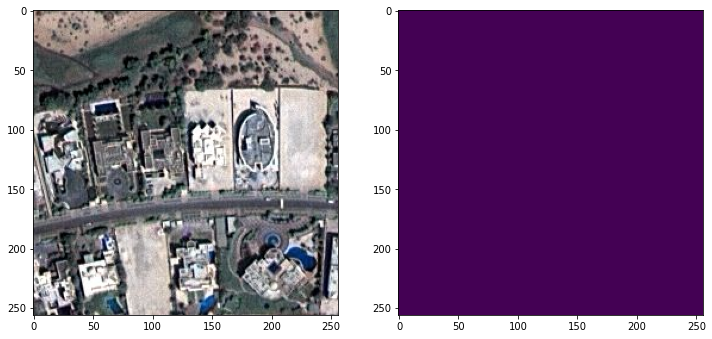

In [16]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

we create the datasets based on our categories

In [17]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


Model creation


In [19]:
#we get the network from an external file 
!wget https://www.dropbox.com/s/sf40f63ae3w01tb/simple_multi_unet_model.py

--2022-02-25 17:17:50--  https://www.dropbox.com/s/sf40f63ae3w01tb/simple_multi_unet_model.py
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/sf40f63ae3w01tb/simple_multi_unet_model.py [following]
--2022-02-25 17:17:51--  https://www.dropbox.com/s/raw/sf40f63ae3w01tb/simple_multi_unet_model.py
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc05ecfe5e77cf875f1e65a88f93.dl.dropboxusercontent.com/cd/0/inline/BgZjNVzi7oWjkOUgsLdoeuJBUvsIGLBkrdXJKlwnz64YxhNP46KGPd9xia4NEAPnzf7gTZy8ItSiyr7GmokdrwA4xyo36CD7xupxBhMvCwZpcp30NqHPcoRl-GAS_cW307v2lL3VJ-y8Tp3AfYGkEsOv/file# [following]
--2022-02-25 17:17:51--  https://uc05ecfe5e77cf875f1e65a88f93.dl.dropboxusercontent.com/cd/0/inline/BgZjNVzi7oWjkOUgsLdoeuJBUvsIGLBkrdXJKlwnz64Yx

In [20]:
#######################################
#Parameters for model
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss
# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')), 
#                               np.ravel(labels,order='C'))
# print(weights)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

from simple_multi_unet_model import multi_unet_model, jacard_coef  

metrics=['accuracy', jacard_coef] #jackard coeficient is to measure similarities between sets

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

we can now fit (train) the model.


In [ ]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100
66/66 [==============================] - 8s 121ms/step - loss: 1.0176 - accuracy: 0.4043 - jacard_coef: 0.1476 - val_loss: 1.0091 - val_accuracy: 0.5275 - val_jacard_coef: 0.1757
Epoch 2/100
66/66 [==============================] - 7s 100ms/step - loss: 1.0077 - accuracy: 0.5377 - jacard_coef: 0.1839 - val_loss: 1.0151 - val_accuracy: 0.4372 - val_jacard_coef: 0.1881
Epoch 3/100
66/66 [==============================] - 7s 100ms/step - loss: 1.0062 - accuracy: 0.5365 - jacard_coef: 0.1885 - val_loss: 1.0071 - val_accuracy: 0.5061 - val_jacard_coef: 0.2030
Epoch 4/100
66/66 [==============================] - 7s 101ms/step - loss: 1.0045 - accuracy: 0.5330 - jacard_coef: 0.1930 - val_loss: 1.0068 - val_accuracy: 0.4964 - val_jacard_coef: 0.2041
Epoch 5/100
66/66 [==============================] - 7s 100ms/step - loss: 1.0040 - accuracy: 0.5293 - jacard_coef: 0.1958 - val_loss: 1.0058 - val_accuracy: 0.5068 - val_jacard_coef: 0.2083
Epoch 6/100
66/66 [==========================

save the model 


In [ ]:
sm.set_framework('tf.keras')
sm.framework()
model.save('models/satellite_standard_unet_100epochs1.hdf5')

using other pre trained models (optional)

we will use Categorical crossentropy: CCE is a loss function that is used in multi-class classification tasks. These are tasks where an example can only belong to one out of many possible categories, and the model must decide which one. Formally, it is designed to quantify the difference between two probability distributions.

In [ ]:
##Standardscaler 
#Using categorical crossentropy as loss: 0.677
sm.set_framework('tf.keras')

sm.framework()
#model.save('models/satellite_standard_unet_100epochs_7May2021.hdf5')
############################################################
#TRY ANOTHE MODEL - WITH PRETRINED WEIGHTS
#Resnet backbone
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

# compile keras model with defined optimozer, loss and metrics
#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model_resnet_backbone.summary())
history2=model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=32, 
          epochs=400,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

#Minmaxscaler
#With weights...[0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]   in Dice loss
#With focal loss only, after 100 epochs val jacard is:               
#With dice + 5 focal, after 100 epochs val jacard is: 0.73 (reached 0.71 in 40 epochs. So faster training but not better result. )
##With dice + 1 focal, after 100 epochs val jacard is:   
    ##Using categorical crossentropy as loss: 0.755 (100 epochs)
#With calc. weights supplied to model.fit: 
 
#Standard scaler
#Using categorical crossentropy as loss: 0.74

We save the model

In [ ]:
model_resnet_backbone.save('models/satellite_standard_unet_100epochs_better.hdf5')

We use a better evaluation metric such as IOU

More info about IOU
https://towardsdatascience.com/iou-a-better-detection-evaluation-metric-45a511185be1#:~:text=Intersection%20over%20Union%20(IoU)%20is,and%20ground%20truth%20bounding%20box.

In [ ]:

###########################################################
#plot the training and validation accuracy and loss at each epoch
history = history2
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

from keras.models import load_model
model = load_model('models/satellite_standard_unet_100epochs_better.hdf5',
                   custom_objects={'dice_loss_plus_2focal_loss': total_loss,
                                   'jacard_coef':jacard_coef})

##################################
# from keras.models import load_model
# model = load_model("/content/models/satellite_standard_unet_100epochs1.hdf5",
#                    custom_objects={'dice_loss_plus_2focal_loss': total_loss,
#                                    'jacard_coef':jacard_coef})

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

results?, let´s try some predictions


In [ ]:
#Predict on a few images

import random
test_img_number = 25#random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

#plot figures
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()